# Imports and Boilerplate

In [ ]:
!mkdir tup_dataset
!gdown --id 1lUzfCDmnUhHAnPnqs3ayOEnMZ8EMJzBY
!unzip tup_dataset.zip -d tup_dataset > /dev/null
!rm tup_dataset.zip

mkdir: cannot create directory ‘tup_dataset’: File exists
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1lUzfCDmnUhHAnPnqs3ayOEnMZ8EMJzBY
To: /content/tup_dataset.zip
100% 430k/430k [00:00<00:00, 166MB/s]
replace tup_dataset/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!pip install -q diffusers transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
import json
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionPipeline, UniPCMultistepScheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device =', device)

data_path = 'tup_dataset'
json_path = os.path.join(data_path, 'meta.json')
if not os.path.exists(json_path):
    raise ValueError('Could not find dataset!')
with open(json_path) as f:
    dataset = json.load(f)
dataset.append(data_path)

Device = cuda


In [ ]:
sd_pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to(device)
sd_pipe.scheduler = UniPCMultistepScheduler.from_config(sd_pipe.scheduler.config)
controlnet = ControlNetModel.from_pretrained("MakiPan/controlnet-encoded-hands-130k", torch_dtype=torch.float16).to(device)
controlnet_pose = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
sd_cnet_pipe = StableDiffusionControlNetPipeline(
        sd_pipe.vae,
        sd_pipe.text_encoder,
        sd_pipe.tokenizer,
        sd_pipe.unet,
        [controlnet, controlnet_pose],
        sd_pipe.scheduler,
        sd_pipe.safety_checker,
        sd_pipe.feature_extractor,
        False
).to(device)
sd_pipe.safety_checker = None
sd_cnet_pipe.safety_checker = None

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
The config attributes {'dropout': 0.0, 'sample_size': 32} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
def pad_or_crop_to_target(img, target_height=100, target_width=100):
    # Get original dimensions
    _, height, width = img.shape

    # If either dimension of the image is larger than the target size, crop to the target size
    if height > target_height or width > target_width:
        start_height = (height - target_height) // 2
        start_width = (width - target_width) // 2
        img = img[:, start_height:start_height + target_height, start_width:start_width + target_width]
    # If the dimensions are smaller, pad to the target size
    else:
        padding_left = (target_width - width) // 2
        padding_right = target_width - width - padding_left
        padding_top = (target_height - height) // 2
        padding_bottom = target_height - height - padding_top

        # Apply padding
        img = F.pad(img, (padding_left, padding_right, padding_top, padding_bottom), value=0)

    return img

def rand_example(dataset_json, hw, n=-1, seed=None):
    generator = torch.Generator()
    if seed is None:
        generator.seed()
    else:
        generator.manual_seed(seed)
    rands = torch.rand(3, generator=generator, device=generator.device).tolist()
    rands_n = torch.randn(1, generator=generator, device=generator.device).tolist()
    banned_ids = [2, 12, 14, 18, 21, 22, 23, 26, 27, 28, 29, 38, 43, 50, 51, 52, 53]
    valid_ids = [x for x in range(len(dataset_json)-1) if x not in banned_ids]
    while n < 0 or n in banned_ids:
        n = int(rands[0] * (len(dataset_json) - len(banned_ids) - 1))
        n = valid_ids[n]
    selected = dataset_json[n]
    img = torch.tensor(np.array(Image.open(os.path.join(dataset_json[-1], selected['name'])))).to(dtype=torch.float32, device=device) / 255.0
    img_pose = torch.tensor(np.array(Image.open(os.path.join(dataset_json[-1], selected['name_pose'])))).to(dtype=torch.float32, device=device) / 255.0
    img = torch.cat([img, img_pose], dim=-1)

    img = img.permute(2, 0, 1)
    img = pad_or_crop_to_target(img, hw[0], hw[1])
    rotangle = (rands_n[0] - 0.5) * 5.0
    offseth = (selected['offset'][0] * hw[0]) + ((rands[1] - 0.5) * (16.0 * (1.0 / 256.0) * hw[0]))
    offsetw = (selected['offset'][1] * hw[1]) + ((rands[2] - 0.5) * (16.0 * (1.0 / 256.0) * hw[1]))
    img = torchvision.transforms.functional.affine(img, rotangle, (offsetw, offseth), 1.0, 0.0, torchvision.transforms.InterpolationMode.NEAREST)
    return img

def decompose_to_rows_cols(n, ratio=1.778):
    rows = round(np.sqrt(n / ratio))
    cols = np.ceil(n / rows)
    return int(rows), int(cols)

def image_grid(imgs, rows, cols):
  w, h = imgs[0].size
  grid = Image.new("RGB", size=(cols * w, rows * h))
  blank = Image.new("RGB", size=(w, h), color=(255, 255, 255))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      grid.paste(img, box=(i % cols * w, i // cols * h))
  for i in range((rows*cols) - len(imgs)):
      j = i + len(imgs)
      grid.paste(blank, box=(j % cols * w, j // cols * h))

  return grid


# Image Generation



In [ ]:
#@markdown ####**Generation Settings:**
Prompt_text = "A young man giving a lukewarm smile and a thumbs up" #@param {type: 'string'}
Negative_prompt_text = '' #@param {type: 'string'}
Num_images = 4 #@param {type: 'integer'}
Enable_extention = True #@param {type: 'boolean'}

You have 2 ControlNets and you have passed 4 prompts. The conditionings will be fixed across the prompts.


  0%|          | 0/20 [00:00<?, ?it/s]

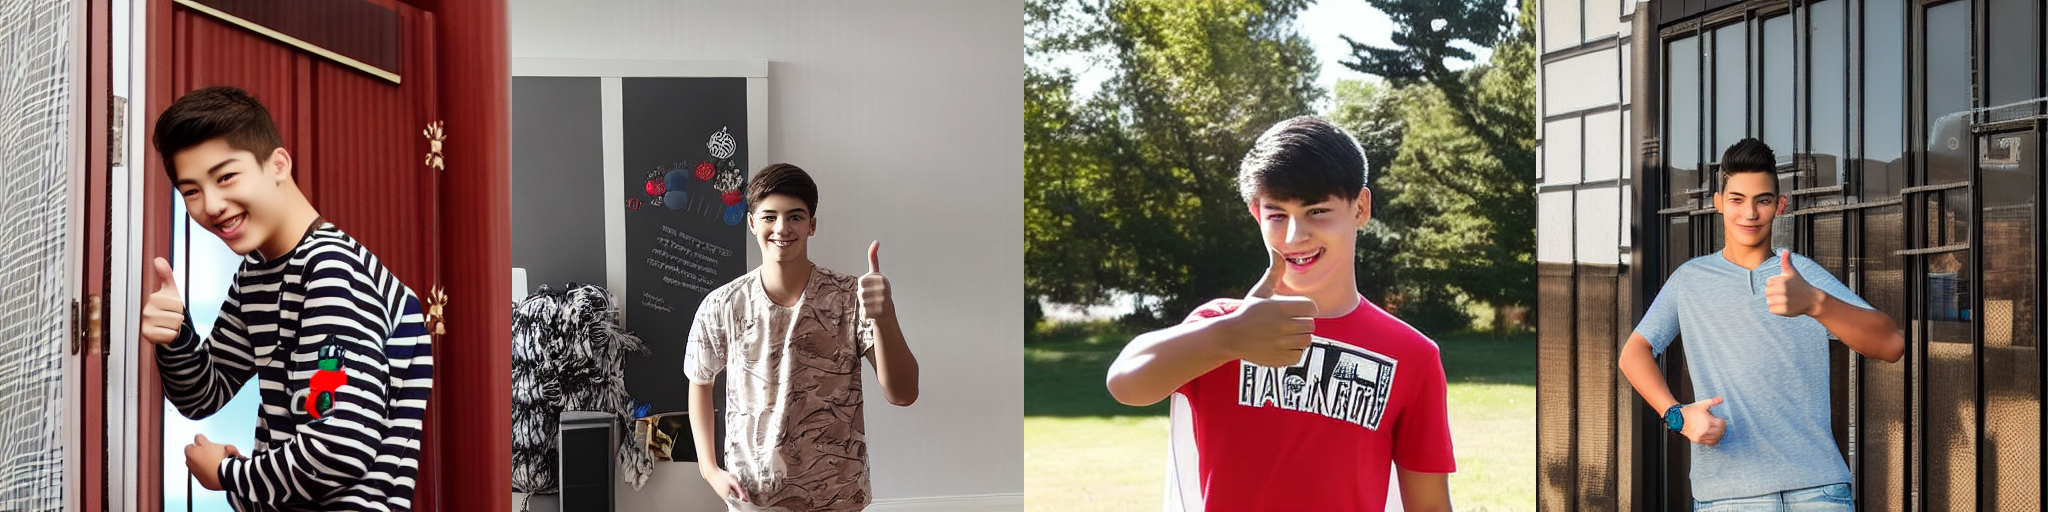

In [ ]:
use_ext = False
activate_ext = [
    'thumbs up',
    'thumb up'
]
for key in activate_ext:
    if key in Prompt_text.lower():
        use_ext = True

if (Negative_prompt_text is None or Negative_prompt_text == '') and use_ext:
      Negative_prompt_text = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, grainy, blurry"

use_ext = use_ext and Enable_extention
if not use_ext:
    pipe = sd_pipe
    sd_out = pipe([Prompt_text] * Num_images, negative_prompt=[Negative_prompt_text] * Num_images, num_inference_steps=20)
else:
    pipe = sd_cnet_pipe
    hw = [pipe.unet.config.sample_size * pipe.vae_scale_factor] * 2
    cond_images = []
    for i in range(Num_images):
      cond_images.append(rand_example(dataset, hw))
    cond_batch = torch.stack(cond_images, dim=0)

    cond_hands = cond_batch[:, :3]
    cond_pose = cond_batch[:, 3:]

    sd_out = pipe([Prompt_text] * Num_images, image=[cond_hands, cond_pose], negative_prompt=[Negative_prompt_text] * Num_images, num_inference_steps=20)



image_grid(sd_out.images, *decompose_to_rows_cols(len(sd_out.images)))
